## 0.2.epoch调参分析

In [11]:
import sys
sys.path = ["../../.."] + sys.path # 切换到项目目录下

import scanpy as sc
import scvelo as scv
import velovgi

In [12]:
from torch_geometric import seed_everything

seed = 0
seed_everything(seed)

1. 读取数据

In [13]:
adata_filename = "/home/huang/PyCode/scRNA/data/Gastrulation/erythroid_lineage.h5ad" # 实验室服务器的数据路径

adata = scv.read(adata_filename)
batch_key = "stage"
cluster_key = "celltype"
adata

AnnData object with n_obs × n_vars = 9815 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

## 预处理

In [14]:
batch_pair_list = None
batch_pair_list = [
    ["E7.0", "E7.25"],
    ["E7.25", "E7.5"],
    ["E7.5", "E7.75"],
    ["E7.75", "E8.0"],
    ["E8.0", "E8.25"],
    ["E8.25", "E8.5"],
]
knn_mask, bnn_mask, subsample_adata = velovgi.pp.preprocess(adata, sample_mode="random", batch_key=batch_key, batch_pair_list=batch_pair_list)

Filtered out 47456 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
calculating knn and bnn mask...
pair_list : [['E7.0', 'E7.25'], ['E7.25', 'E7.5'], ['E7.5', 'E7.75'], ['E7.75', 'E8.0'], ['E8.0', 'E8.25'], ['E8.25', 'E8.5']]
smoothing...
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## 断点训练

In [15]:
# max_epochs = 500
# sep = 100

max_epochs = 100
sep = 20

model_epoch_sep_savedir = "./model/epoch_parameter_adjustment/(%s,%s)"%(sep, max_epochs) # TODO: 这里保存路径以后需要更改
log_epoch_sep_save_dir = "./log/epoch_parameter_adjustment/(%s,%s)"%(sep, max_epochs)


epoch_list = range(0, max_epochs+1, sep)[1:] # TOOD: 数据量越大，查看的epoch间隔应该越小


# 每次断点指定模型训练的epoch
sep_epoch_list = [epoch_list[0]] 
for i in range(1, len(epoch_list)):
    sep_epoch_list.append(epoch_list[i]-epoch_list[i-1])
# sep_epoch_list.append(max_epochs-epoch_list[-1]) # 最后这个不保存
sep_epoch_list

[20, 20, 20, 20, 20]

In [16]:
from pytorch_lightning import loggers

velovgi.tl.VELOVGI.setup_anndata(adata=subsample_adata, spliced_layer="Ms", unspliced_layer="Mu")
velovgi_model = velovgi.tl.VELOVGI(subsample_adata)

for i in range(len(epoch_list)):
    epoch = epoch_list[i]
    sep_epoch = sep_epoch_list[i] # 此次断点训练的epoch数目
    print(epoch, sep_epoch)
    name = "%d_epoch(max_epochs=%d)"%(epoch, max_epochs) # 模型的训练名称
    logger = loggers.TensorBoardLogger(save_dir=log_epoch_sep_save_dir, name=name) # 构造日志文件
    
    velovgi_model.train(max_epochs=sep_epoch, logger=logger, checkpoint_mode="checkpoint")
    velovgi_model.save("%s/%s"%(model_epoch_sep_savedir, name))# 模型保存

20 20
初始训练，初始化runner参数
choosing neighbor minibatch


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_parameter_adjustment/(20,100)/20_epoch(max_epochs=100)


Epoch 20/20: 100%|██████████| 20/20 [01:57<00:00,  6.08s/it, loss=6.85e+05, v_num=0]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [01:57<00:00,  5.89s/it, loss=6.85e+05, v_num=0]
40 20
断点继续训练
断点的epochs： 20


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_parameter_adjustment/(20,100)/40_epoch(max_epochs=100)


Epoch 20/20: 100%|██████████| 20/20 [02:02<00:00,  6.15s/it, loss=5.79e+05, v_num=0]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [02:02<00:00,  6.15s/it, loss=5.79e+05, v_num=0]
60 20
断点继续训练
断点的epochs： 20


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_parameter_adjustment/(20,100)/60_epoch(max_epochs=100)


Epoch 20/20: 100%|██████████| 20/20 [02:03<00:00,  6.19s/it, loss=4.83e+05, v_num=0]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [02:03<00:00,  6.19s/it, loss=4.83e+05, v_num=0]
80 20
断点继续训练
断点的epochs： 20


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_parameter_adjustment/(20,100)/80_epoch(max_epochs=100)


Epoch 20/20: 100%|██████████| 20/20 [02:07<00:00,  6.42s/it, loss=3.95e+05, v_num=0]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [02:07<00:00,  6.36s/it, loss=3.95e+05, v_num=0]
100 20
断点继续训练
断点的epochs： 20


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_parameter_adjustment/(20,100)/100_epoch(max_epochs=100)


Epoch 20/20: 100%|██████████| 20/20 [02:08<00:00,  6.36s/it, loss=3.42e+05, v_num=0]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [02:08<00:00,  6.40s/it, loss=3.42e+05, v_num=0]


## 读取断点训练结果，看看整体和基因速率图

1. 读取断点训练结果

In [17]:
name_list =[]
adata_list = []

for i in range(len(epoch_list)):
    epoch = epoch_list[i]
    name = "%d_epoch(max_epochs=%d)"%(epoch, max_epochs) # 模型的训练名称
    name_list.append(name)
    # 提取模型
    # model = velovgi.tl.VELOVGI.load("%s/%s"%(model_epoch_sep_savedir, name), adata=subsample_adata, use_gpu=True)
    model = velovgi.tl.VELOVGI.load("%s/%s"%(model_epoch_sep_savedir, name), adata=subsample_adata, use_gpu=False)
     # 输出结果
    velovgi.tl.add_velovi_outputs_to_adata(subsample_adata, model)
    tmp_adata = adata.copy()
    velovgi.pp.moment_recover(tmp_adata, subsample_adata)
    adata_list.append(tmp_adata)
adata_list

INFO     File ./model/epoch_parameter_adjustment/(20,100)/20_epoch(max_epochs=100)/model.pt already downloaded     
INFO     File ./model/epoch_parameter_adjustment/(20,100)/40_epoch(max_epochs=100)/model.pt already downloaded     
INFO     File ./model/epoch_parameter_adjustment/(20,100)/60_epoch(max_epochs=100)/model.pt already downloaded     
INFO     File ./model/epoch_parameter_adjustment/(20,100)/80_epoch(max_epochs=100)/model.pt already downloaded     
INFO     File ./model/epoch_parameter_adjustment/(20,100)/100_epoch(max_epochs=100)/model.pt already downloaded    


[AnnData object with n_obs × n_vars = 9815 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
     uns: 'celltype_colors', 'neighbors', 'sample_recover'
     obsm: 'X_pca', 'X_umap'
     layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'velocity_u', 'fit_t'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 9815 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
     uns:

2. 绘制整体速率图

20_epoch(max_epochs=100)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/24 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 10 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


40_epoch(max_epochs=100)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/24 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 9 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


60_epoch(max_epochs=100)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/24 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 7 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


80_epoch(max_epochs=100)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/24 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 10 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


100_epoch(max_epochs=100)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/24 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 10 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


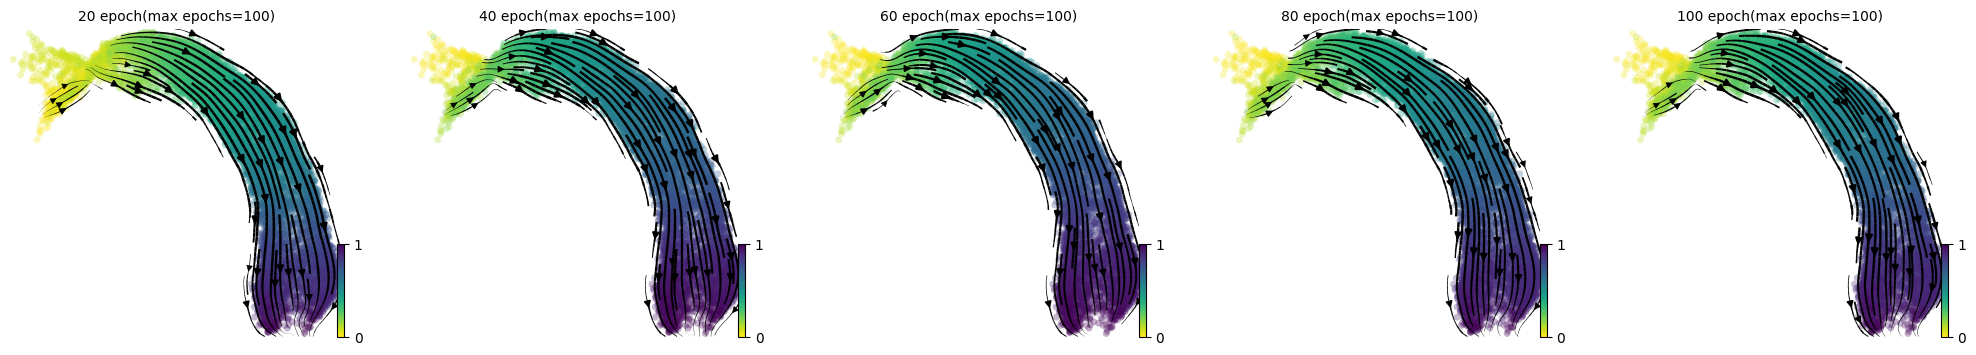

In [18]:
n = len(epoch_list)
fig, ax = velovgi.pl.calc_fig(n)
for i in range(n):
    print(name_list[i])
    name = name_list[i]
    tmp_adata = adata_list[i]
    scv.tl.velocity_graph(tmp_adata) # 转移矩阵计算
    scv.tl.velocity_pseudotime(tmp_adata) # 速率的伪时间计算
    scv.pl.velocity_embedding_stream(tmp_adata, color="velocity_pseudotime", ax=ax[i], title=name, show=False)

## 调参选择

目前这里看来，应该是到60左右最好。但实际最好还是看tensorborad的loss面板，发现实际对应的原本的50左右的epoch。